# Tabular Playground Series - Jun 2021

## Dependencies

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

SEED = 2502
DATA_PATH = "../data/tabular-playground-series-jun-2021/"

In [3]:
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

PyTorch версия: 2.10.0+cu128
CUDA доступна: True
Используемое устройство: cuda


## Data

In [4]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_test = pd.read_csv(DATA_PATH + "test.csv")

df_train['target'] = df_train['target'].str.replace("Class_", '').astype(int)
df_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,...,0,0,0,0,0,0,2,0,0,6
1,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,6
2,2,0,0,0,0,0,1,0,3,0,...,0,0,0,0,1,0,0,0,0,2
3,3,0,0,7,0,1,5,2,2,0,...,0,4,0,2,2,0,4,3,0,8
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


### EDA

In [5]:
df_train.shape

(200000, 77)

200000 rows \
77 columns:
- 1 id
- 75 anonymized features
- 1 target (multiclass)

In [6]:
set(df_train.dtypes.values)

{dtype('int64')}

In [7]:
num_classes = df_train['target'].nunique()
num_classes

9

9 classes

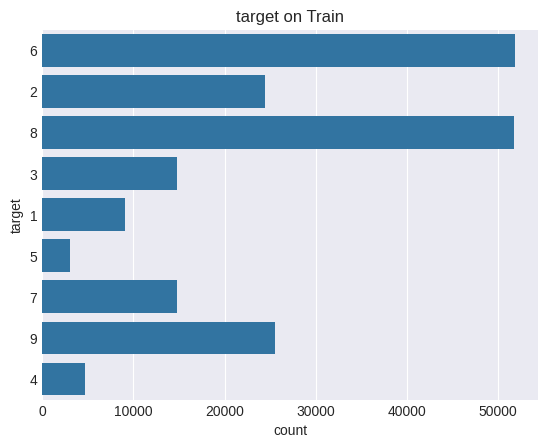

In [8]:
sns.countplot(df_train['target'].astype(str))
plt.title("target on Train")
plt.show()

### Dataset preparing

In [13]:
cols2drop = ['id']
target = 'target'
features = df_train.drop(columns=cols2drop + [target], errors='ignore').columns

X = df_train[features].to_numpy()
y = df_train[target].to_numpy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

scaler_w = StandardScaler()
X_train = scaler_w.fit_transform(X_train)
X_val = scaler_w.transform(X_val)
X_test = scaler_w.transform(X_test)

In [15]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)
X_test_t = torch.FloatTensor(X_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Model

In [ ]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = MultiClassClassifier(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
print(model)